# Chapter 18 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
import matplotlib.pyplot as plt
import mlba
import numpy as np
import pandas as pd
from sktime.forecasting.ardl import ARDL
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.trend import PolynomialTrendForecaster, TrendForecaster
from sktime.pipeline import make_pipeline
from sktime.split import temporal_train_test_split
from sktime.transformations.series.boxcox import LogTransformer
from sktime.utils.plotting import plot_series
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline

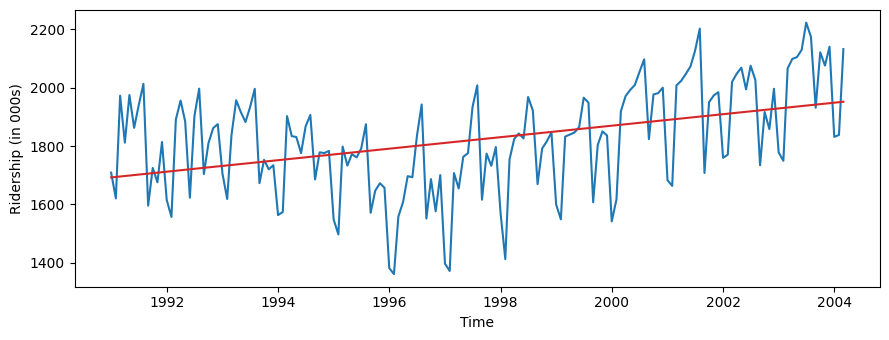

In [3]:
# load data and convert to time series
Amtrak_df = mlba.load_data('Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date,
                          name='Ridership')
ridership_ts = ridership_ts.to_period('M')

# fit a linear trend model to the time series
forecaster = TrendForecaster()
forecaster.fit(ridership_ts)

fig, ax = plt.subplots(figsize=[9, 3.5])
plot_series(ridership_ts, forecaster.predict(ridership_ts.index),
            markers=['', ''], ax=ax,
            colors=['C0', 'C3'],
            x_label='Time', y_label='Ridership (in 000s)')
plt.tight_layout()
plt.show()

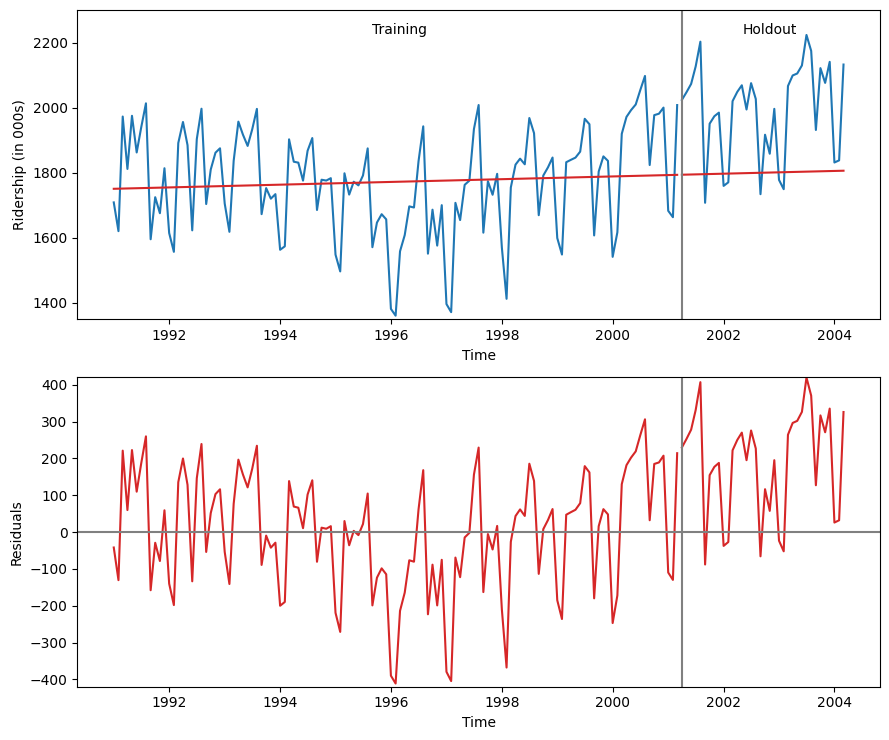

In [4]:
# partition the data
nHoldout = 36
train_ts, holdout_ts = temporal_train_test_split(ridership_ts, test_size=nHoldout)

# fit linear trend model using training set and predict on holdout (test) set
forecaster_linear = TrendForecaster()
forecaster_linear.fit(train_ts)

def plot_model(forecaster, train_ts, holdout_ts, *, fh=None, train_X=None, holdout_X=None, ymax=2300):
    if fh is None:
        fh = ForecastingHorizon(holdout_ts.index, is_relative=False)

    fig, axes = plt.subplots(nrows=2, figsize=(9, 7.5))
    ax = plot_series(train_ts, holdout_ts,
        forecaster.predict(train_ts.index, X=train_X), forecaster.predict(fh, X=holdout_X),
        ax=axes[0], x_label='Time', y_label='Ridership (in 000s)',
        colors=['C0', 'C0', 'C3', 'C3'], markers=['', '', '', ''])
    ax.axvline(train_ts.index[-1], color='grey')
    ax.set_ylim(1350, ymax)
    ax.text(train_ts.index[len(train_ts) // 2], ymax-75, "Training", horizontalalignment='center')
    ax.text(holdout_ts.index[len(holdout_ts) // 2], ymax-75, "Holdout", horizontalalignment='center')

    train_residual = forecaster.predict_residuals(train_ts, X=train_X)
    holdout_residual = forecaster.predict_residuals(holdout_ts, X=holdout_X)
    ax = plot_series(train_residual, holdout_residual,
        ax=axes[1], x_label='Time', y_label='Residuals',
        colors=['C3', 'C3'], markers=['', ''])
    ax.axhline(y=0, color='grey')
    ax.axvline(train_ts.index[-1], color='grey')
    ax.set_ylim(-420, 420)
    return axes

axes = plot_model(forecaster_linear, train_ts, holdout_ts)
plt.tight_layout()
plt.show()

In [5]:
print(f'Intercept: {forecaster.regressor_.intercept_:.2f}')
print(f'Trend: {forecaster.regressor_.coef_[0]:.3f}')
mlba.regressionSummary(y_true=train_ts, y_pred=forecaster.predict(train_ts.index))
mlba.regressionSummary(y_true=holdout_ts, y_pred=forecaster.predict(holdout_ts.index))

Intercept: 1278.53
Trend: 1.642

Regression statistics

Mean Error (ME) : -20.4879
Root Mean Squared Error (RMSE) : 166.6704
Mean Absolute Error (MAE) : 131.2283
Mean Percentage Error (MPE) : -2.0054
Mean Absolute Percentage Error (MAPE) : 7.7195

Regression statistics

Mean Error (ME) : 70.0002
Root Mean Squared Error (RMSE) : 157.4290
Mean Absolute Error (MAE) : 143.3292
Mean Percentage Error (MPE) : 3.0050
Mean Absolute Percentage Error (MAPE) : 7.1496


 Partial output

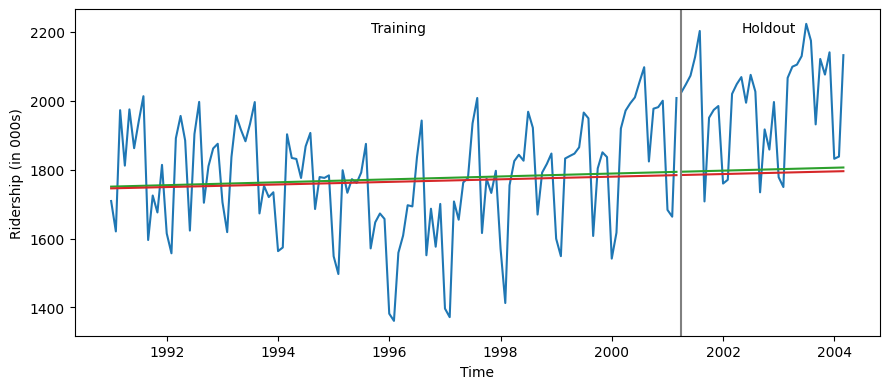

In [6]:
forecaster_expo = make_pipeline(
    LogTransformer(),
    TrendForecaster(),
)
forecaster_expo.fit(train_ts)

fig, ax = plt.subplots(figsize=(9, 4))
plot_series(train_ts, holdout_ts,
        forecaster_linear.predict(train_ts.index),
        forecaster_linear.predict(holdout_ts.index),
        forecaster_expo.predict(train_ts.index),
        forecaster_expo.predict(holdout_ts.index),
        x_label='Time', y_label='Ridership (in 000s)',
        colors=['C0', 'C0', 'C2', 'C2', 'C3', 'C3'],
        markers=['', '', '', '', '', ''], ax=ax)
ax.axvline(train_ts.index[-1], color='grey')
ax.text(train_ts.index[len(train_ts) // 2], 2200, "Training", horizontalalignment='center')
ax.text(holdout_ts.index[len(holdout_ts) // 2], 2200, "Holdout", horizontalalignment='center')
plt.tight_layout()
plt.show()

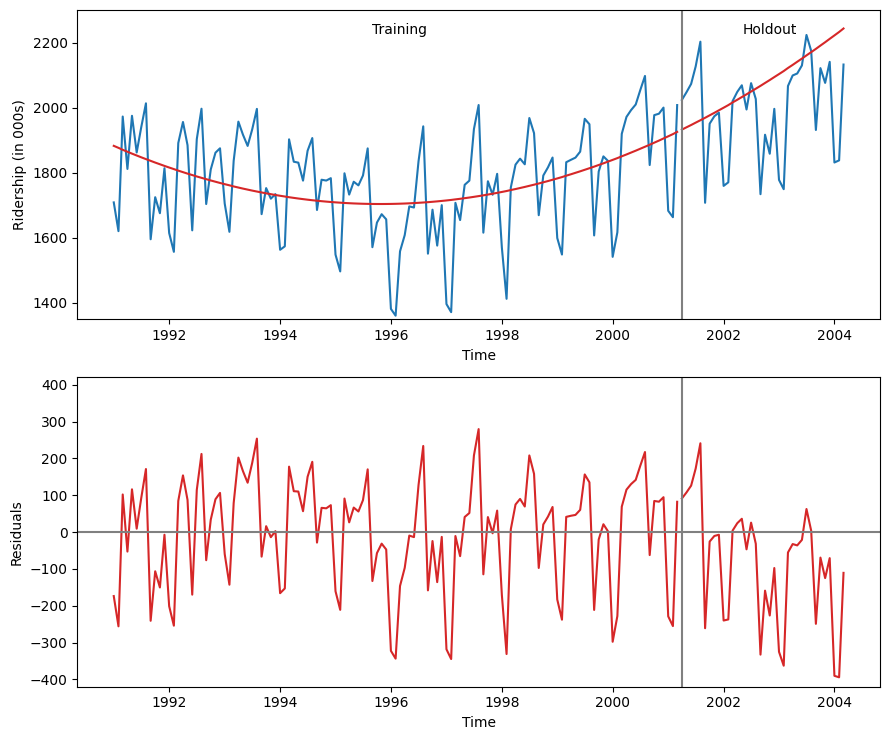

In [7]:
forecaster_poly = PolynomialTrendForecaster(degree=2)
forecaster_poly.fit(train_ts)

plot_model(forecaster_poly, train_ts, holdout_ts)
plt.tight_layout()
plt.show()

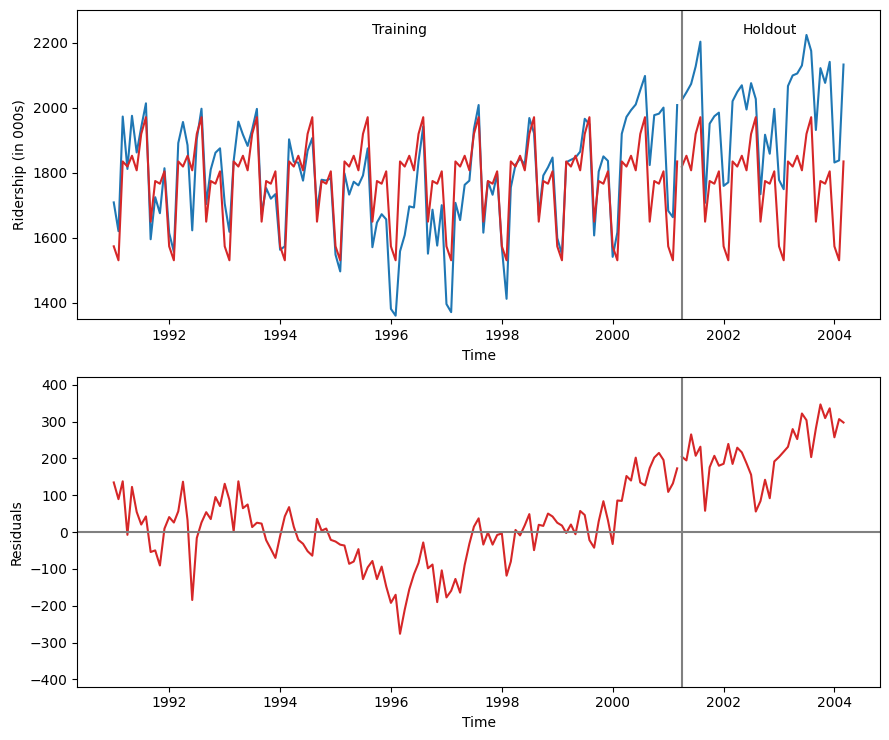

In [8]:
forecaster_season = ARDL(lags=0, trend='c', seasonal=True)
forecaster_season.fit(train_ts)

plot_model(forecaster_season, train_ts, holdout_ts)
plt.tight_layout()
plt.show()

 
Setting the lags parameter to 0 means that we are not including any autoregressive terms in the model. 
The trend parameter is set to 'c' to include a constant term in the model. The seasonal parameter is 
set to True to include seasonality in the model; the frequency of the seasonality is inferred from the data.

In [9]:
forecaster_season.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:              Ridership   No. Observations:                  123
Model:                 Seas. ARDL(0,)   Log Likelihood                -736.380
Method:               Conditional MLE   S.D. of innovations             96.340
Date:                Mon, 10 Feb 2025   AIC                           1498.759
Time:                        14:33:27   BIC                           1535.318
Sample:                    01-31-1991   HQIC                          1513.609
                         - 03-31-2001                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1573.9722     30.578     51.475      0.000    1513.381    1634.564
s(2,12)      -42.9302     43.243     -0.993      0.323    -128.620      42.759
s(3,12)      260.7677     43.243      6.030      0.000     175.078     346.457
s(4,12)      245.0919     44.311      5.531      0.000     157.286     332.897
s(5,12)      278.2222     44.311      6.279      0.000     190.417     366.028
s(6,12)      233.4598     44.311      5.269      0.000     145.654     321.265
s(7,12)      345.3265     44.311      7.793      0.000     257.521     433.132
s(8,12)      396.6595     44.311      8.952      0.000     308.854     484.465
s(9,12)       75.7615     44.311      1.710      0.090     -12.044     163.567
s(10,12)     200.6076     44.311      4.527      0.000     112.802     288.413
s(11,12)     192.3552     44.311      4.341      0.000     104.550     280.161
s(12,12)     230.4151     44.311      5.200      0.000     142.610     318.221
==============================================================================
"""

 Partial output

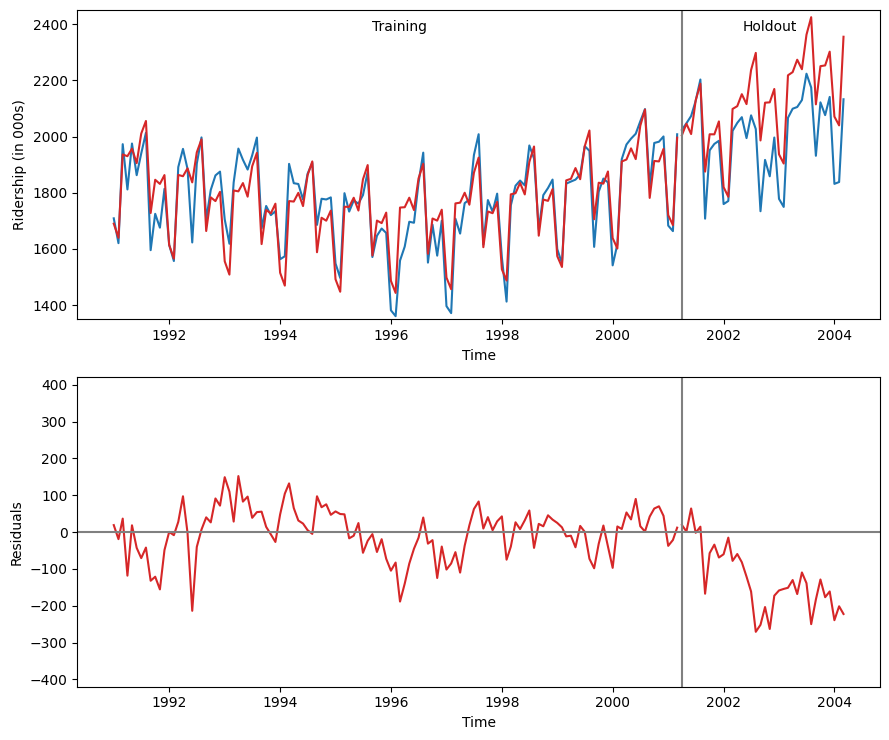

In [10]:
# create data frames for the exogenous variable required to add a quadratic trend
t_sqr = pd.Series(np.arange(1, 1 + len(ridership_ts))**2, index=ridership_ts.index)
train_X = pd.DataFrame({'t**2': t_sqr.loc[train_ts.index]})
holdout_X = pd.DataFrame({'t**2': t_sqr.loc[holdout_ts.index]})

forecaster_quadseason = ARDL(lags=0, order=0, trend='ct', seasonal=True)
forecaster_quadseason.fit(train_ts, X=train_X)

plot_model(forecaster_quadseason, train_ts, holdout_ts, train_X=train_X,
           holdout_X=holdout_X, ymax=2450)
plt.tight_layout()
plt.show()

In [11]:
forecaster_quadseason.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:              Ridership   No. Observations:                  123
Model:               Seas. ARDL(0, 0)   Log Likelihood                -691.268
Method:               Conditional MLE   S.D. of innovations             66.761
Date:                Mon, 10 Feb 2025   AIC                           1412.536
Time:                        14:33:27   BIC                           1454.719
Sample:                    01-31-1991   HQIC                          1429.670
                         - 03-31-2001                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1696.9794     27.675     61.318      0.000    1642.128    1751.831
trend         -7.1559      0.729     -9.812      0.000      -8.601      -5.710
s(2,12)      -43.2458     30.241     -1.430      0.156    -103.182      16.690
s(3,12)      260.0149     30.242      8.598      0.000     200.076     319.954
s(4,12)      260.6175     31.021      8.401      0.000     199.135     322.100
s(5,12)      293.7966     31.020      9.471      0.000     232.316     355.278
s(6,12)      248.9615     31.020      8.026      0.000     187.481     310.442
s(7,12)      360.6340     31.020     11.626      0.000     299.153     422.115
s(8,12)      411.6513     31.021     13.270      0.000     350.169     473.134
s(9,12)       90.3162     31.022      2.911      0.004      28.831     151.801
s(10,12)     214.6037     31.024      6.917      0.000     153.115     276.092
s(11,12)     205.6711     31.026      6.629      0.000     144.178     267.165
s(12,12)     242.9294     31.029      7.829      0.000     181.430     304.429
t**2.L0        0.0607      0.006     10.660      0.000       0.049       0.072
==============================================================================
"""

 Partial output

In [12]:
pd.DataFrame({
  'Ridership': ridership_ts,
  'Lag-1 series': ridership_ts.shift(1),
  'Lag-2 series': ridership_ts.shift(2),
}).head(24)

,Ridership,Lag-1 series,Lag-2 series
1991-01,1708.917,NaN,NaN
1991-02,1620.586,1708.917,NaN
1991-03,1972.715,1620.586,1708.917
1991-04,1811.665,1972.715,1620.586
1991-05,1974.964,1811.665,1972.715
1991-06,1862.356,1974.964,1811.665
1991-07,1939.860,1862.356,1974.964
1991-08,2013.264,1939.860,1862.356
1991-09,1595.657,2013.264,1939.860
1991-10,1724.924,1595.657,2013.264


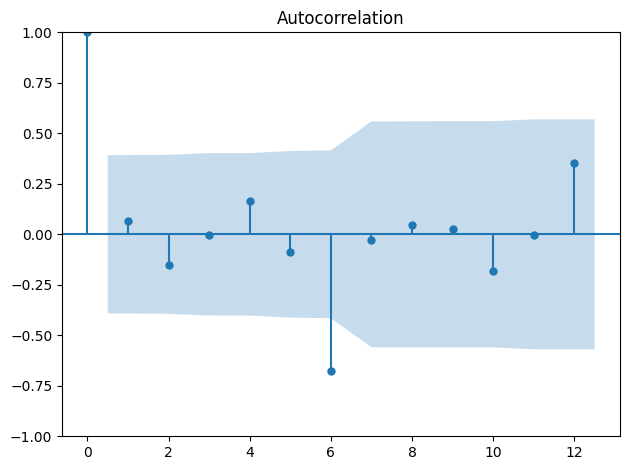

In [13]:
plot_acf(train_ts['1991-01-01':'1993-01-01'])
plt.tight_layout()
plt.show()

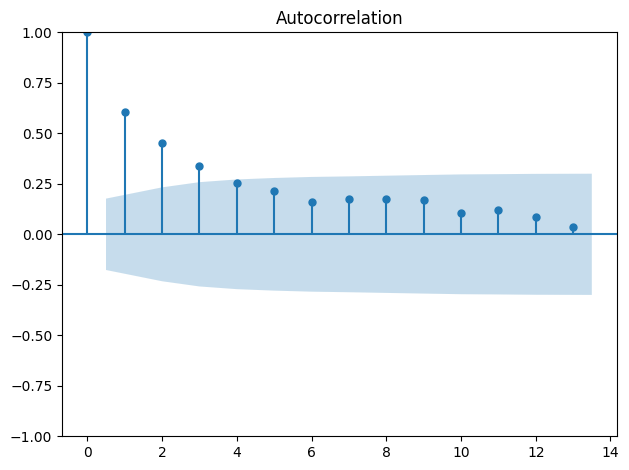

In [14]:
plot_acf(forecaster_quadseason.predict_residuals(train_ts, X=train_X), lags=13)
plt.tight_layout()
plt.show()

 
You can use the function `acf` to get the autocorrelation values directly. 

In [15]:
from statsmodels.tsa.stattools import acf
acf(forecaster_quadseason.predict_residuals(train_ts, X=train_X))

array([ 1.        ,  0.60405883,  0.44983171,  0.3373083 ,  0.25329034,
        0.21565844,  0.15901326,  0.17676683,  0.17553762,  0.17140882,
        0.10739472,  0.11976519,  0.08512942,  0.03621337, -0.04100296,
       -0.10220097, -0.08359282, -0.10871958, -0.13125876, -0.19609773,
       -0.18755508])

In [16]:
residuals = forecaster_quadseason.predict_residuals()
arima = ARIMA(order=(1, 0, 0))
arima.fit(residuals)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  123
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -663.542
Date:                Mon, 10 Feb 2025   AIC                           1333.084
Time:                        14:33:28   BIC                           1341.520
Sample:                    01-31-1991   HQIC                          1336.511
                         - 03-31-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0542      5.214      0.010      0.992     -10.166      10.274
ar.L1          0.5998      0.076      7.908      0.000       0.451       0.748
sigma2      2825.9877    291.027      9.710      0.000    2255.585    3396.391
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):                23.64
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

 Partial output

In [17]:
print(arima.predict(fh=1))
print(arima.predict_quantiles(fh=1, alpha=[0.025, 0.1, 0.9, 0.975]))

2001-04    7.315792
Freq: M, Name: Ridership, dtype: float64
         Ridership                                  
             0.025      0.100      0.900       0.975
2001-04 -96.875933 -60.811515  75.443099  111.507516


 
  Demonstration of the calculation of the forecasted residual for April 2001

In [18]:
intercept = arima.get_fitted_params()['intercept']
# 0.05420776179700896
ar = arima.get_fitted_params()['ar.L1']
# 0.5997562550622262
last_residual = residuals.iloc[-1]
# 12.107558346705446
intercept + ar * last_residual
# 7.315791613764466
# this is identical to the prediction

7.315791613764466

 
  Calculation of the improved forecast for April 2001

In [19]:
model_forecast = forecaster_quadseason.predict(fh=1, X=holdout_X)
residual_forecast = arima.predict(fh=1)
forecast = model_forecast + residual_forecast
actual = holdout_ts.iloc[0]
print(f'{model_forecast=}')
print(f'{residual_forecast=}')
print(f'{forecast=}')
print(f'{actual=}')

model_forecast=2001-04    2004.270893
Freq: M, Name: Ridership, dtype: float64
residual_forecast=2001-04    7.315792
Freq: M, Name: Ridership, dtype: float64
forecast=2001-04    2011.586684
Freq: M, Name: Ridership, dtype: float64
actual=2023.792


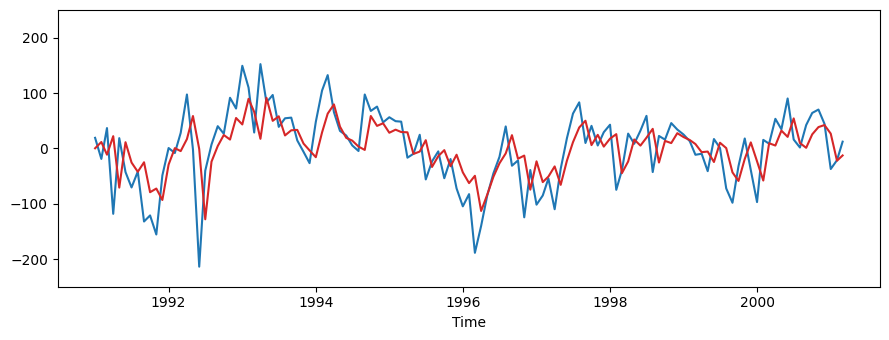

In [20]:
fig, ax = plt.subplots(figsize=[9, 3.5])
plot_series(residuals, arima.predict(train_ts.index),
            markers=['', ''], ax=ax, colors=['C0', 'C3'],
            x_label='Time', y_label='')
ax.set_ylim(-250, 250)
plt.tight_layout()
plt.show()

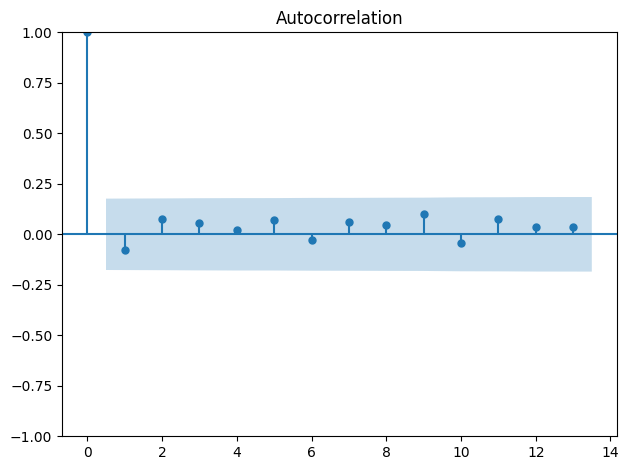

In [21]:
plot_acf(arima.predict(train_ts.index) - residuals, lags=13)
plt.tight_layout()
plt.show()

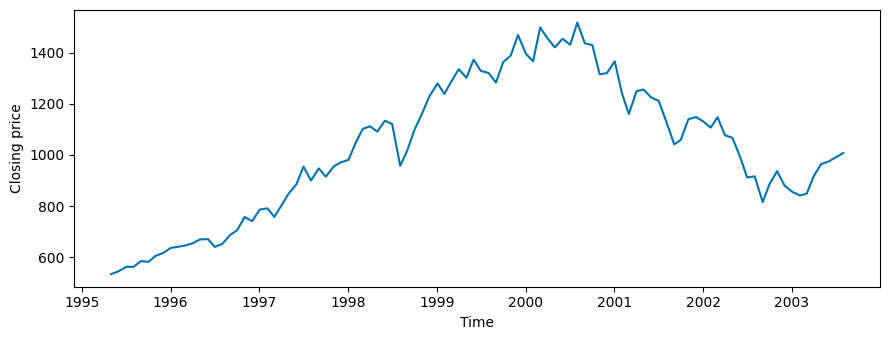

In [22]:
sp500_df = mlba.load_data('SP500.csv')
sp500_ts = pd.Series(sp500_df['Close'].values,
                     index=pd.to_datetime(sp500_df.Date, format='%d-%b-%y'))
fig, ax = plt.subplots(figsize=[9, 3.5])
plot_series(sp500_ts, ax=ax, markers=[''],
            x_label='Time', y_label='Closing price')
plt.tight_layout()
plt.show()

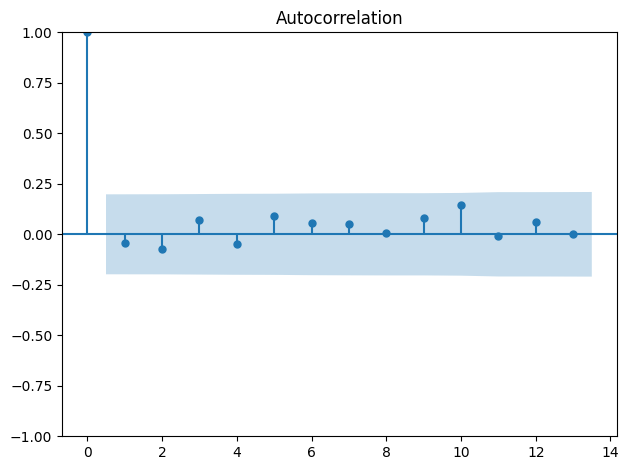

In [23]:
sp500_df = mlba.load_data('SP500.csv')
sp500_ts = pd.Series(sp500_df['Close'].values,
                     index=pd.to_datetime(sp500_df.Date, format='%d-%b-%y'))
sp500_ts = sp500_ts.to_period('D')

delta = sp500_ts.shift(1) - sp500_ts
delta = delta[1:-1]  # remove first and last element
plot_acf(delta, lags=13)
plt.tight_layout()
plt.show()

In [24]:
arima = ARIMA(order=(1, 0, 0))
arima.fit(sp500_ts)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -540.051
Date:                Mon, 10 Feb 2025   AIC                           1086.102
Time:                        14:33:29   BIC                           1093.918
Sample:                    05-01-1995   HQIC                          1089.265
                         - 08-01-2003                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.7695     15.356      0.962      0.336     -15.328      44.867
ar.L1          0.9834      0.016     61.961      0.000       0.952       1.014
sigma2      2776.8412    382.861      7.253      0.000    2026.448    3527.234
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                 3.07
Prob(Q):                              0.63   Prob(JB):                         0.22
Heteroskedasticity (H):               3.13   Skew:                            -0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

 Partial output